<h1>Airbnb listing data for NYC 2019</h1>

<p>Airbnb is one of the largest short-term rental services in the world.  As such, they have millions of listings, many of which are in metropolitan areas like LA and NYC.  They currently do not have a public API to get listing data, but fortunately a recent <a href=https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data>dataset</a> is available on Kaggle specifically for NYC.</p>

<p>The download contains a CSV file which is readily consumed by pandas</p>

In [1]:
import pandas as pd
df = pd.read_csv('AB_NYC_2019.csv')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
id                                48895 non-null int64
name                              48879 non-null object
host_id                           48895 non-null int64
host_name                         48874 non-null object
neighbourhood_group               48895 non-null object
neighbourhood                     48895 non-null object
latitude                          48895 non-null float64
longitude                         48895 non-null float64
room_type                         48895 non-null object
price                             48895 non-null int64
minimum_nights                    48895 non-null int64
number_of_reviews                 48895 non-null int64
last_review                       38843 non-null object
reviews_per_month                 38843 non-null float64
calculated_host_listings_count    48895 non-null int64
availability_365                  48895 non-null int64

<p>High level info indicates over 48,000 entries.  While this is not a very large dataset, it should be sufficient for modeling.  We are also dealing with geographic rather than time series data.  Notable columns are <b>neighbourhood, latitude, longitude, room_type, price, minimum_nights, number_of_reviews, reviews_per_month, calculated_host_listings_count, availability_365</b>.  Other data may not be as relevant for the purpose of this project.</p>
<br/>

In [3]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


<p>From initial numerical observations we see right away that certain columns can be excluded from analysis (<b>id, host_id</b>).  It does not make sense to use their mean and standard deviation.</p>

<p>There may be some issues with outliers.  The lowest <b>price</b> recorded is 0, which does not make sense given that property owners and managers are looking for revenue.  The highest <b>price</b> is 10,000, which does not seem realistic.  Other columns like <b>minimum_nights, reviews_per_month, and calculated_host_listings_count</b> may have outliers as well.  There is a large gap between their <b>max</b> and <b>75th percentile</b> values.</p>
<br/>

In [4]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

<p>A listing of all columns suggests that certain columns can be translated into categorical data: <b>neighbourhood, neighbourhood_group, room_type</b></p>
<br/>

<p>Of course we should also peek into the dataframe head and tail</p>

In [5]:
df.head(10)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129
6,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,2017-10-05,0.40,1,0
7,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,2019-06-24,3.47,1,220
8,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80178,-73.96723,Private room,79,2,118,2017-07-21,0.99,1,0
9,5238,Cute & Cozy Lower East Side 1 bdrm,7549,Ben,Manhattan,Chinatown,40.71344,-73.99037,Entire home/apt,150,1,160,2019-06-09,1.33,4,188


In [6]:
df.tail(10)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
48885,36482809,Stunning Bedroom NYC! Walking to Central Park!!,131529729,Kendall,Manhattan,East Harlem,40.79633,-73.93605,Private room,75,2,0,NaN,NaN,2,353
48886,36483010,Comfy 1 Bedroom in Midtown East,274311461,Scott,Manhattan,Midtown,40.75561,-73.96723,Entire home/apt,200,6,0,NaN,NaN,1,176
48887,36483152,Garden Jewel Apartment in Williamsburg New York,208514239,Melki,Brooklyn,Williamsburg,40.71232,-73.94220,Entire home/apt,170,1,0,NaN,NaN,3,365
48888,36484087,"Spacious Room w/ Private Rooftop, Central loca...",274321313,Kat,Manhattan,Hell's Kitchen,40.76392,-73.99183,Private room,125,4,0,NaN,NaN,1,31
48889,36484363,QUIT PRIVATE HOUSE,107716952,Michael,Queens,Jamaica,40.69137,-73.80844,Private room,65,1,0,NaN,NaN,2,163
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2
48894,36487245,Trendy duplex in the very heart of Hell's Kitchen,68119814,Christophe,Manhattan,Hell's Kitchen,40.76404,-73.98933,Private room,90,7,0,NaN,NaN,1,23


In [7]:
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

<p>We see that <b>name, host_name, last_review, reviews_per_month</b> are affected by missing values.  The host's name and to a lesser extent the listing's name are not critical to this project's modeling.  Perhaps some NLP analysis could be done on <b>last_review</b>, but it is missing for almost 20% of the listings.</p>
<br/>

<p>A key piece of missing data is time series data for price and availability, which will be explored in the next sections.</p>

<p>For a more detailed analysis, let's look at the original raw data that has been scraped from <a href="airbnb.com">Airbnb</a>.  The <b>listings.csv</b> can be found <a href="http://data.insideairbnb.com/united-states/ny/new-york-city/2019-12-04/data/listings.csv.gz">here</a>.  Data for other cities can also be found <a href="http://insideairbnb.com/get-the-data.html">here</a>.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline
listings_df = pd.read_csv('listings.csv')

/Users/blai/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3050: DtypeWarning: Columns (61,62,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<br/>
<p>There are certain columns that have mixed data. Lets take a look at the general structure of the listings as well as those columns.</p>

In [3]:
print(listings_df.info())
print(listings_df.columns)
for col_index in [60, 61, 93, 94]:
    print(listings_df.columns[col_index])
listings_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50599 entries, 0 to 50598
Columns: 106 entries, id to reviews_per_month
dtypes: float64(22), int64(21), object(63)
memory usage: 40.9+ MB
None
Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       ...
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'],
      dtype='object', length=106)
price
weekly_price
requires_license
license


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2595,https://www.airbnb.com/rooms/2595,20191204162729,2019-12-07,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...","- Spacious (500+ft²), immaculate and nicely fu...","Beautiful, spacious skylit studio in the heart...",none,Centrally located in the heart of Manhattan ju...,...,f,f,strict_14_with_grace_period,t,t,1,1,0,0,0.39
1,3831,https://www.airbnb.com/rooms/3831,20191204162729,2019-12-07,Cozy Entire Floor of Brownstone,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Greetings! We own a double-duplex brownst...,Urban retreat: enjoy 500 s.f. floor in 1899 br...,none,Just the right mix of urban center and local n...,...,f,f,moderate,f,f,1,1,0,0,4.67
2,5099,https://www.airbnb.com/rooms/5099,20191204162729,2019-12-06,Large Cozy 1 BR Apartment In Midtown East,My large 1 bedroom apartment has a true New Yo...,I have a large 1 bedroom apartment centrally l...,My large 1 bedroom apartment has a true New Yo...,none,My neighborhood in Midtown East is called Murr...,...,f,f,moderate,t,t,1,1,0,0,0.60
3,5121,https://www.airbnb.com/rooms/5121,20191204162729,2019-12-06,BlissArtsSpace!,NaN,HELLO EVERYONE AND THANKS FOR VISITING BLISS A...,HELLO EVERYONE AND THANKS FOR VISITING BLISS A...,none,NaN,...,f,f,strict_14_with_grace_period,f,f,1,0,1,0,0.38
4,5178,https://www.airbnb.com/rooms/5178,20191204162729,2019-12-05,Large Furnished Room Near B'way,Please don’t expect the luxury here just a bas...,"You will use one large, furnished, private roo...",Please don’t expect the luxury here just a bas...,none,"Theater district, many restaurants around here.",...,f,f,strict_14_with_grace_period,f,f,1,0,1,0,3.52


<br/>
<p>As we will see later, those mixed columns are not necessary.  There are also more entries than in the first dataset that we looked at (hopefully for more accurate modeling).  Let's drop the mixed columns and other columns that have irrelevant data, majority incomplete data, or data that can be found in other tables.</p>

In [4]:
# calendar values scraped in a small window between 2019-12-04 and 2019-12-07

listings_clean = listings_df.drop(['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', \
    'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', \
    'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', \
    'host_name', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', \
    'host_acceptance_rate', 'host_since', 'host_listings_count', 'host_total_listings_count', \
    'host_verifications', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_has_profile_pic', \
    'host_identity_verified', 'host_neighbourhood', 'street', 'neighbourhood', 'city', 'state', 'zipcode', \
    'market', 'smart_location', 'country_code', 'country', 'is_location_exact', 'instant_bookable', \
    'is_business_travel_ready', 'license', 'jurisdiction_names', 'review_scores_value', 'requires_license', \
    'review_scores_communication', 'bed_type', 'amenities', 'weekly_price', 'monthly_price', \
    'security_deposit', 'guests_included', 'minimum_minimum_nights', 'maximum_minimum_nights', \
    'minimum_maximum_nights', 'maximum_maximum_nights', 'calendar_updated', 'has_availability', \
    'calendar_last_scraped', 'number_of_reviews_ltm', 'first_review', 'last_review', 'review_scores_accuracy', \
    'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_location', 'cancellation_policy', \
    'require_guest_profile_picture', 'require_guest_phone_verification', 'calculated_host_listings_count', \
    'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', \
    'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'cleaning_fee', 'extra_people', \
    'number_of_reviews', 'review_scores_rating', 'square_feet', 'property_type', 'minimum_nights_avg_ntm', \
    'maximum_nights_avg_ntm', 'price', 'minimum_nights', 'maximum_nights', 'availability_30', \
    'availability_60', 'availability_90', 'availability_365'], axis=1)
print(listings_clean.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50599 entries, 0 to 50598
Data columns (total 10 columns):
id                              50599 non-null int64
neighbourhood_cleansed          50599 non-null object
neighbourhood_group_cleansed    50599 non-null object
latitude                        50599 non-null float64
longitude                       50599 non-null float64
room_type                       50599 non-null object
accommodates                    50599 non-null int64
bathrooms                       50548 non-null float64
bedrooms                        50536 non-null float64
beds                            50467 non-null float64
dtypes: float64(5), int64(2), object(3)
memory usage: 3.9+ MB
None


<br/>
<p>Columns <b>bathrooms, bedrooms, beds</b> have missing data, but thankfully not a lot.  We will try to clean that up.  Let's also rename a couple columns</p>

In [5]:
listings_clean.rename(columns={
    'neighbourhood_cleansed':'neighbourhood',
    'neighbourhood_group_cleansed': 'neighbourhood_group'
}, inplace=True)
listings_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50599 entries, 0 to 50598
Data columns (total 10 columns):
id                     50599 non-null int64
neighbourhood          50599 non-null object
neighbourhood_group    50599 non-null object
latitude               50599 non-null float64
longitude              50599 non-null float64
room_type              50599 non-null object
accommodates           50599 non-null int64
bathrooms              50548 non-null float64
bedrooms               50536 non-null float64
beds                   50467 non-null float64
dtypes: float64(5), int64(2), object(3)
memory usage: 3.9+ MB


<br/>
<p>We see some possible outliers for <b>accommodates, bathrooms, bedrooms, beds</b>.</p>

In [6]:
listings_clean.describe()

,id,latitude,longitude,accommodates,bathrooms,bedrooms,beds
count,5.059900e+04,50599.000000,50599.000000,50599.000000,50548.000000,50536.000000,50467.000000
mean,2.137380e+07,40.728743,-73.950762,2.860630,1.150332,1.181217,1.549626
std,1.242864e+07,0.055004,0.047606,1.900865,0.442102,0.760981,1.131406
min,2.595000e+03,40.499790,-74.247870,1.000000,0.000000,0.000000,0.000000
25%,1.009891e+07,40.689550,-73.982930,2.000000,1.000000,1.000000,1.000000
50%,2.154642e+07,40.722880,-73.955050,2.000000,1.000000,1.000000,1.000000
75%,3.271780e+07,40.763030,-73.934200,4.000000,1.000000,1.000000,2.000000
max,4.058402e+07,40.916860,-73.712990,25.000000,15.500000,21.000000,40.000000


<br/>
<p>Check for duplicate latitude and longitude value pairs, which most likely means duplicate listings</p>

In [7]:
# https://stackoverflow.com/questions/44481768/remove-duplicate-rows-from-pandas-dataframe-where-only-some-columns-have-the-sam
# https://stackoverflow.com/questions/16167829/in-pandas-how-can-i-reset-index-without-adding-a-new-column

listings_clean = listings_clean.drop_duplicates(subset=['latitude', 'longitude']).reset_index(drop=True)
listings_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50587 entries, 0 to 50586
Data columns (total 10 columns):
id                     50587 non-null int64
neighbourhood          50587 non-null object
neighbourhood_group    50587 non-null object
latitude               50587 non-null float64
longitude              50587 non-null float64
room_type              50587 non-null object
accommodates           50587 non-null int64
bathrooms              50536 non-null float64
bedrooms               50524 non-null float64
beds                   50455 non-null float64
dtypes: float64(5), int64(2), object(3)
memory usage: 3.9+ MB


<br/>
<p>Look at non-numerical columns to see if they can be categorized.</p>

In [8]:
# http://benalexkeen.com/mapping-categorical-data-in-pandas/

print(listings_clean.room_type.value_counts())
print(listings_clean.neighbourhood_group.value_counts())
print(listings_clean.neighbourhood.value_counts())
listings_clean['room_type_cat'] = listings_clean.room_type.astype('category')
listings_clean['neighbourhood_group_cat'] = listings_clean.neighbourhood_group.astype('category')
print(listings_clean.room_type_cat.cat.codes.value_counts())
print(listings_clean.neighbourhood_group_cat.cat.codes.value_counts())


Entire home/apt    26134
Private room       22780
Shared room         1256
Hotel room           417
Name: room_type, dtype: int64
Manhattan        22062
Brooklyn         20736
Queens            6196
Bronx             1215
Staten Island      378
Name: neighbourhood_group, dtype: int64
Bedford-Stuyvesant            3973
Williamsburg                  3933
Harlem                        2746
Bushwick                      2504
Hell's Kitchen                2052
                              ... 
Bay Terrace, Staten Island       1
New Dorp                         1
Fort Wadsworth                   1
Willowbrook                      1
Woodrow                          1
Name: neighbourhood, Length: 223, dtype: int64
0    26134
2    22780
3     1256
1      417
dtype: int64
2    22062
1    20736
3     6196
0     1215
4      378
dtype: int64


<p><b>Neighbourhood_group</b> has too many values to be categorized, but the other ones are fine for categorization.</p>
<p>Now we can break the data down by home/apartment listings vs. "single room" type listings because entire homes are usually more expensive than single rooms.</p>

In [9]:
home_listings = listings_clean.loc[listings_clean.room_type_cat.cat.codes == 0]
print(home_listings.bedrooms.value_counts())
print(home_listings.beds.value_counts())
print(home_listings.bathrooms.value_counts())

1.0     13018
2.0      6214
0.0      4140
3.0      2034
4.0       476
5.0       133
6.0        41
7.0        17
8.0        10
10.0        5
9.0         4
21.0        1
14.0        1
12.0        1
Name: bedrooms, dtype: int64
1.0     11605
2.0      8097
3.0      3258
4.0      1428
0.0       697
5.0       521
6.0       243
7.0       104
8.0        54
9.0        36
10.0       16
11.0       14
12.0       11
13.0        7
14.0        4
16.0        3
18.0        2
17.0        2
15.0        1
26.0        1
40.0        1
21.0        1
22.0        1
Name: beds, dtype: int64
1.0     22189
2.0      2255
1.5       889
2.5       339
3.0       208
3.5        77
4.0        49
0.0        37
0.5        26
4.5        23
5.0        13
6.0         5
5.5         4
7.0         2
8.0         1
7.5         1
6.5         1
15.5        1
Name: bathrooms, dtype: int64


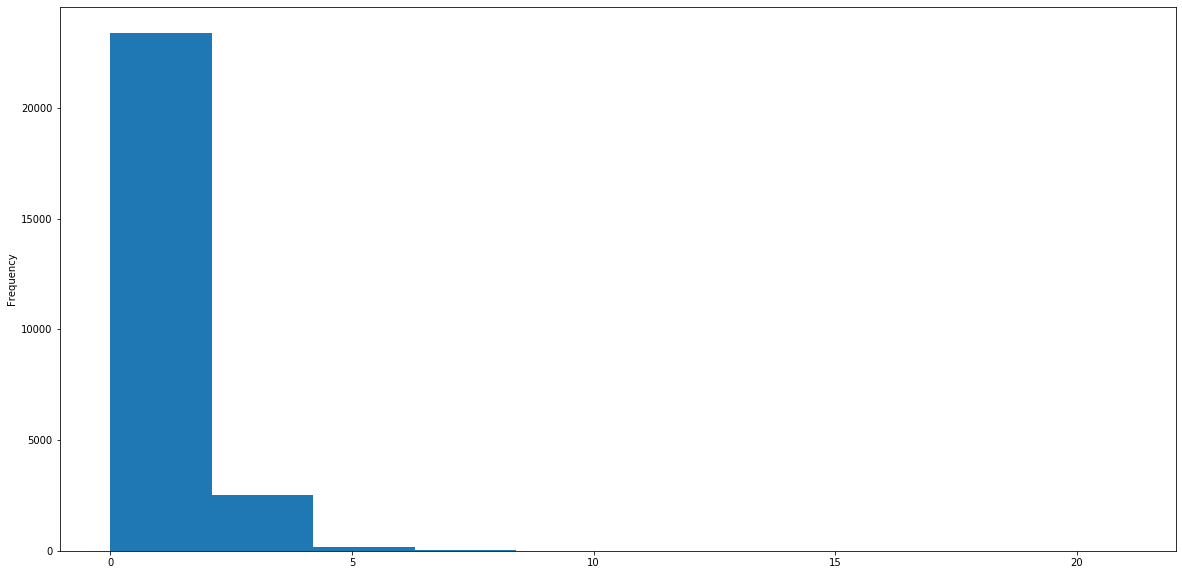

In [10]:
home_listings.bedrooms.plot(kind='hist', figsize=(20, 10))

<p>Home listings are heavily skewed toward single bedroom.  Perhaps we can approximate <b>bedrooms, bathrooms, beds</b> as exponential distributions.</p>
<p>Let's do the same analysis for single room type listings</p>

In [11]:
room_listings = listings_clean.loc[listings_clean.room_type_cat.cat.codes != 0]
print(room_listings.bedrooms.value_counts())
print(room_listings.beds.value_counts())
print(room_listings.bathrooms.value_counts())

1.0     23163
2.0       572
0.0       502
3.0       124
4.0        48
6.0        11
5.0         7
11.0        1
8.0         1
Name: bedrooms, dtype: int64
1.0     20076
2.0      2613
0.0       785
3.0       547
4.0       217
5.0        43
6.0        36
7.0        14
12.0        6
8.0         6
11.0        2
21.0        1
10.0        1
9.0         1
Name: beds, dtype: int64
1.0    20389
2.0     1867
1.5     1598
3.0      160
2.5      137
0.0       81
0.5       77
4.0       48
3.5       20
6.0       18
6.5       13
5.0        4
7.0        2
5.5        1
4.5        1
Name: bathrooms, dtype: int64


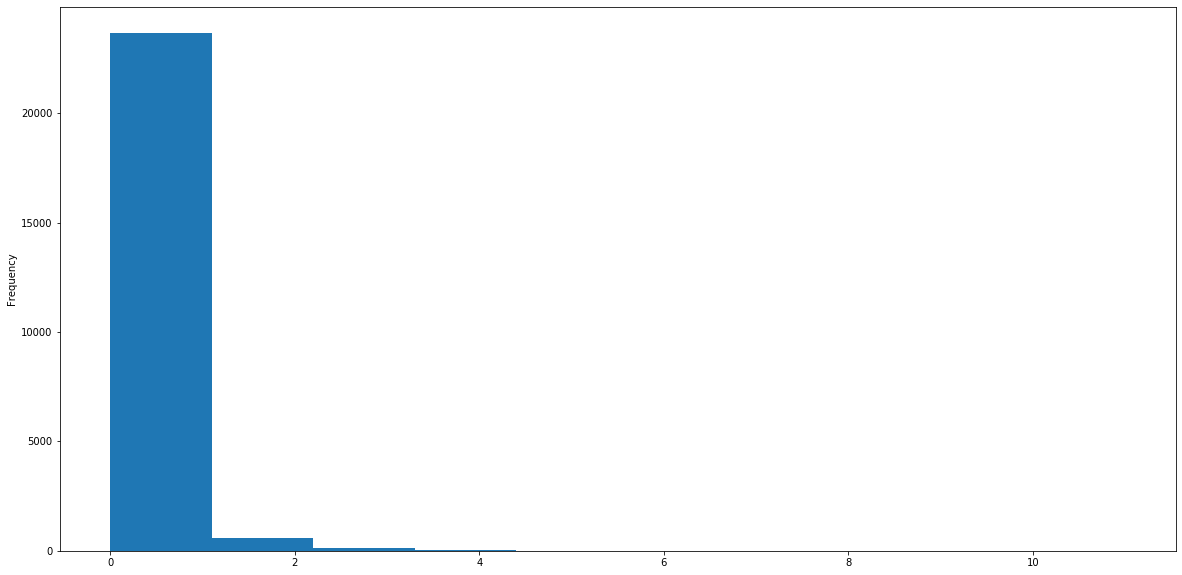

In [12]:
room_listings.bedrooms.plot(kind='hist', figsize=(20, 10))

<p>We get similar results to home listings.</p>

<p>Let's do some data cleaning by filling in the 0 or missing <b>bedrooms, bathrooms, beds</b> values for homes/apts.  We will assume that 0.001 degree latitude or longitude <a href=https://gizmodo.com/how-precise-is-one-degree-of-longitude-or-latitude-1631241162">is about 100 m</a>.  Let's average over an area of 200 m radius from homes/apts that have missing data.  We will group by <b>neighbourhood</b> when calculating the mean.</p>

In [13]:
lat_diff = 0.002
long_diff = 0.002
def avg_of_neighbors(row, col_name, col_index):
    item = row[col_index]
    room_type = row[5]
    lat = row[3]
    long = row[4]
    if room_type == 'Entire home/apt' and (item == 0 or math.isnan(item)):
        item = listings_clean[col_name].loc[(listings_clean.latitude > lat - lat_diff) \
            & (listings_clean.latitude < lat + lat_diff) \
            & (listings_clean.longitude > long - long_diff) \
            & (listings_clean.longitude < long + long_diff)].groupby(by=listings_clean.neighbourhood).mean().round()[0]
        if item == 0:
            item = 1
        row[col_index] = item
    return row

listings_clean = listings_clean.apply(avg_of_neighbors, col_name='bathrooms', col_index=7, axis=1)
listings_clean = listings_clean.apply(avg_of_neighbors, col_name='bedrooms', col_index=8, axis=1)
listings_clean = listings_clean.apply(avg_of_neighbors, col_name='beds', col_index=9, axis=1)

<br/>
<p>The remaining 0 or missing listings should be of single room type, so we will just assume 1 bedroom, 1 bathroom, and 1 bed.</p>

In [14]:
# https://kanoki.org/2019/07/17/pandas-how-to-replace-values-based-on-conditions/

pd.isna(listings_clean.bedrooms).sum()
listings_clean['bedrooms'] = listings_clean.bedrooms.fillna(value=1)
listings_clean['bathrooms'] = listings_clean.bathrooms.fillna(value=1)
listings_clean['beds'] = listings_clean.beds.fillna(value=1)
listings_clean.loc[listings_clean.bedrooms == 0, 'bedrooms'] = 1
listings_clean.loc[listings_clean.bathrooms == 0, 'bathrooms'] = 1
listings_clean.loc[listings_clean.beds == 0, 'beds'] = 1

In [15]:
print(listings_clean.bedrooms.value_counts())
print(listings_clean.bathrooms.value_counts())
print(listings_clean.beds.value_counts())

1.0     40726
2.0      6941
3.0      2163
4.0       524
5.0       140
6.0        52
7.0        17
8.0        11
10.0        5
9.0         4
14.0        1
21.0        1
11.0        1
12.0        1
Name: bedrooms, dtype: int64
1.0     42746
2.0      4123
1.5      2487
2.5       476
3.0       368
0.5       103
3.5        97
4.0        97
4.5        24
6.0        23
5.0        17
6.5        14
5.5         5
7.0         4
8.0         1
15.5        1
7.5         1
Name: bathrooms, dtype: int64
1.0     33008
2.0     10992
3.0      3810
4.0      1645
5.0       564
6.0       279
7.0       118
8.0        60
9.0        37
12.0       17
10.0       17
11.0       16
13.0        7
14.0        4
16.0        3
18.0        2
17.0        2
21.0        2
15.0        1
22.0        1
40.0        1
26.0        1
Name: beds, dtype: int64


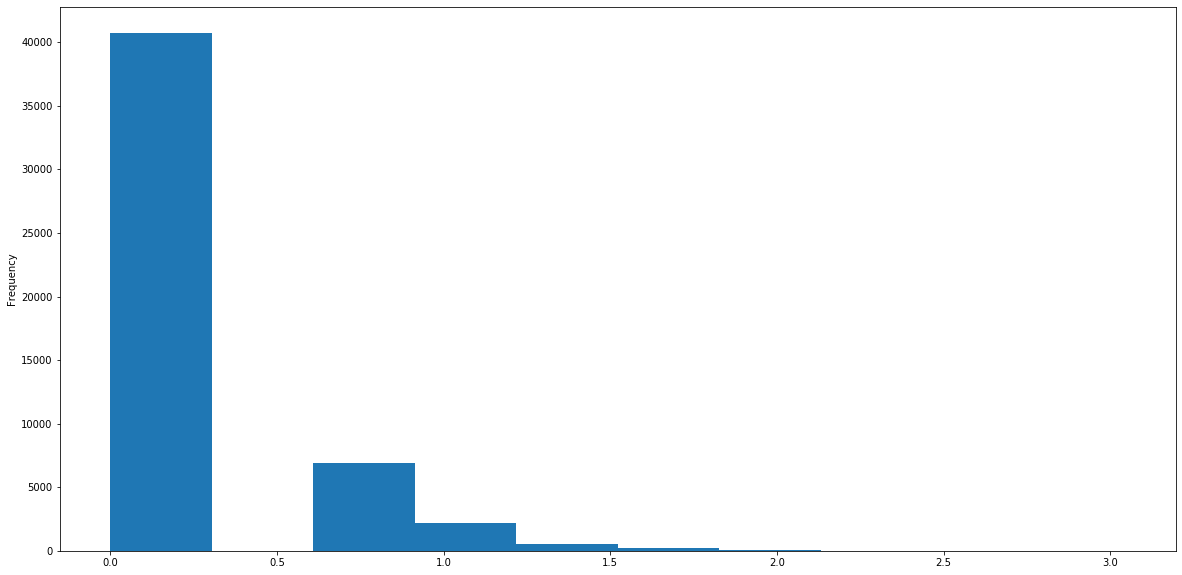

In [16]:
np.log(listings_clean.bedrooms).plot(kind='hist', figsize=(20, 10))

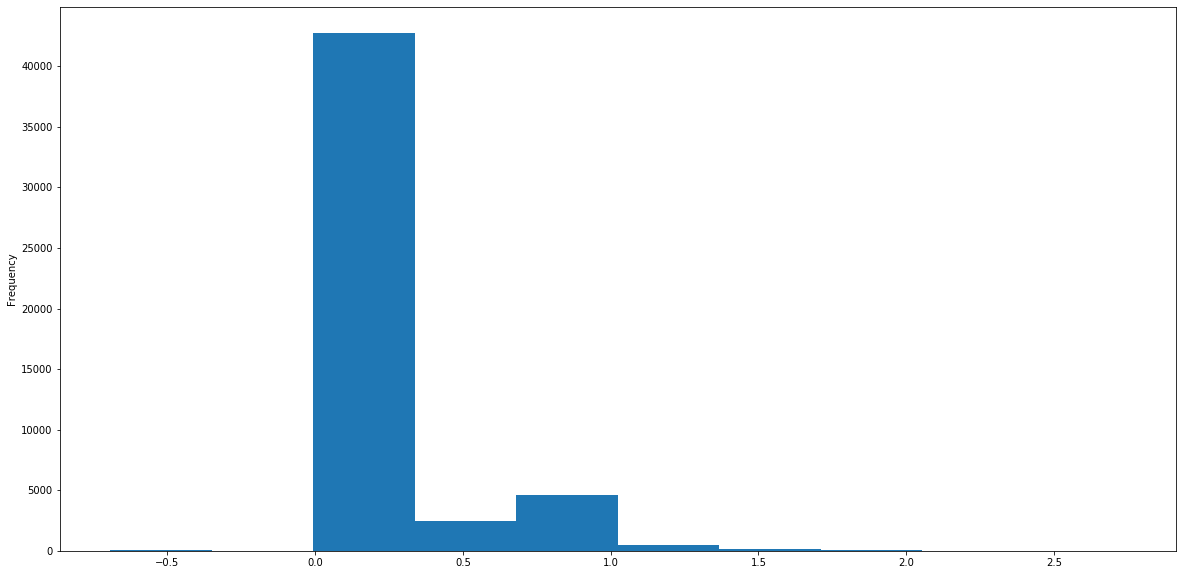

In [17]:
np.log(listings_clean.bathrooms).plot(kind='hist', figsize=(20, 10))

<p>After <b>bedrooms, bathrooms, beds</b> cleanup, we are able to run np.log to see a more detail in the distributions.  They are approximately exponential (again skewed toward 1).</p>

<p>Final check on the listings for any missing data.</p>

In [18]:
listings_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50587 entries, 0 to 50586
Data columns (total 12 columns):
id                         50587 non-null int64
neighbourhood              50587 non-null object
neighbourhood_group        50587 non-null object
latitude                   50587 non-null float64
longitude                  50587 non-null float64
room_type                  50587 non-null object
accommodates               50587 non-null int64
bathrooms                  50587 non-null float64
bedrooms                   50587 non-null float64
beds                       50587 non-null float64
room_type_cat              50587 non-null object
neighbourhood_group_cat    50587 non-null object
dtypes: float64(5), int64(2), object(5)
memory usage: 4.6+ MB


<br/>
<p>Now let's take a look at the time series data for availability, price, and nights.  <a href=http://data.insideairbnb.com/united-states/ny/new-york-city/2019-12-04/data/calendar.csv.gz><b>Calendar.csv</b></a> comes from the same <a href="http://insideairbnb.com/get-the-data.html">source</a> as <b>listings.csv</b></p>.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline
calendar_df = pd.read_csv('calendar.csv', parse_dates=['date'])

<br/>
<p>This time we don't have to deal with columns of mixed data, nor do we have a large number of columns like in the <b>listings_clean</b> table.  We do, however, have over 18 million entries, which makes sense given that this is time series data over a year for 50,000+ listings.  We will have to clean up availability and price.</p>

In [21]:
print(calendar_df.info())
print(calendar_df.columns)
calendar_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18470156 entries, 0 to 18470155
Data columns (total 7 columns):
listing_id        int64
date              datetime64[ns]
available         object
price             object
adjusted_price    object
minimum_nights    float64
maximum_nights    float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 986.4+ MB
None
Index(['listing_id', 'date', 'available', 'price', 'adjusted_price',
       'minimum_nights', 'maximum_nights'],
      dtype='object')


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,19812,2019-12-05,f,$105.00,$105.00,3.0,90.0
1,2595,2019-12-06,f,$175.00,$175.00,10.0,1125.0
2,2595,2019-12-07,f,$175.00,$175.00,10.0,1125.0
3,2595,2019-12-08,f,$175.00,$175.00,10.0,1125.0
4,2595,2019-12-09,f,$175.00,$175.00,10.0,1125.0


<br/>
<p>On checking for equal distribution of all listings over the relevant time period (assumed for this step to be a year), we see a problem with <b>listing_id</b> 15268792.  Let's just remove it, since it is not worth the effort to build a year's worth of data for that one listing.</p>

In [22]:
print(calendar_df.listing_id.value_counts())
calendar_clean = calendar_df[calendar_df.listing_id != 15268792]


25512622    368
32678719    368
28138840    368
30069091    368
24285044    368
           ... 
27926502    365
18992796    365
21677053    365
30226855    365
15268792      6
Name: listing_id, Length: 50599, dtype: int64


<br/>
<p>Since this data set was captured in 2019, we must clean up dates that have year 2020.  Then drop any duplicate <b>listing_id, date</b> combos.  Then check that all days add up to a calendar year for each <b>listing_id</b>.</p>

In [23]:
# https://stackoverflow.com/questions/50674011/replace-the-year-in-pandas-datetime-column
# https://stackoverflow.com/questions/28773342/truncate-timestamp-column-to-hour-precision-in-pandas-dataframe

calendar_clean['date'] = calendar_clean['date'].mask(calendar_clean['date'].dt.year == 2020,
                            calendar_clean['date'] - pd.to_timedelta(1, unit='Y') + pd.to_timedelta(12, unit='h'))
calendar_clean['date'] = calendar_clean['date'].dt.floor('D')

/Users/blai/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pandas/util/_decorators.py:208: FutureWarning: M and Y units are deprecated and will be removed in a future version.
  return func(*args, **kwargs)
/Users/blai/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pandas/core/tools/timedeltas.py:134: FutureWarning: M and Y units are deprecated and will be removed in a future version.
  result = Timedelta(r, unit)
<ipython-input-23-cf40ae5a4fe9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calendar_clean['date'] = calendar_clean['date'].mask(calendar_clean['date'].dt.year == 2020,
<ipython-input-23-cf40ae5a4fe9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [24]:
calendar_clean = calendar_clean.drop_duplicates(subset=['listing_id', 'date']).reset_index(drop=True)
print(calendar_clean.listing_id.value_counts())

327521      365
7756711     365
31877537    365
14961122    365
201992      365
           ... 
37055580    365
13186007    365
18549136    365
34646244    365
30226855    365
Name: listing_id, Length: 50598, dtype: int64


<br/>
<p>Verify that all listing_id values can be found in the <b>listings_clean</b> table.  If not, then remove rows with listing_id values don't exist in the other table.</p>

In [25]:
# https://stackoverflow.com/questions/28901683/pandas-get-rows-which-are-not-in-other-dataframe

ids_match = calendar_clean.listing_id.isin(listings_clean.id)
print(ids_match.value_counts())

True     18463890
False        4380
Name: listing_id, dtype: int64


In [26]:
calendar_clean = calendar_clean[calendar_clean.listing_id.isin(listings_clean.id)]
calendar_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18463890 entries, 0 to 18468269
Data columns (total 7 columns):
listing_id        int64
date              datetime64[ns]
available         object
price             object
adjusted_price    object
minimum_nights    float64
maximum_nights    float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 1.1+ GB


<br/>
<p>Translate all <b>available</b> values to boolean.</p>

In [27]:
print(calendar_clean.available.value_counts())
calendar_clean.loc[calendar_clean.available == 't', 'available'] = True
calendar_clean.loc[calendar_clean.available == 'f', 'available'] = False
print(calendar_clean.available.value_counts())

f    12320331
t     6143559
Name: available, dtype: int64
False    12320331
True      6143559
Name: available, dtype: int64


<br/>
<p>Less than 1% of the entries have <b>adjusted_price</b> not equal to <b>price</b>, but we will use <b>adjusted_price</b> anyway and clean it up to be numerical</p>

In [28]:
calendar_clean[calendar_clean.price != calendar_clean.adjusted_price]

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
8232,20734,2019-12-06,False,$134.00,$127.00,3.0,29.0
8419,20734,2019-12-07,False,$134.00,$127.00,3.0,29.0
8420,20734,2019-12-08,False,$134.00,$127.00,3.0,29.0
8421,20734,2019-12-09,False,$134.00,$127.00,3.0,29.0
8422,20734,2019-12-10,False,$134.00,$127.00,3.0,29.0
...,...,...,...,...,...,...,...
18402175,40482221,2019-12-01,False,$74.00,$63.00,1.0,365.0
18402176,40482221,2019-12-02,False,$74.00,$63.00,1.0,365.0
18402177,40482221,2019-12-03,False,$74.00,$63.00,1.0,365.0
18402178,40482221,2019-12-04,False,$74.00,$63.00,1.0,365.0


In [29]:
calendar_clean['price_cleansed'] = calendar_clean.adjusted_price\
.str.replace('$', '').str.replace(',', '').astype('float')

In [30]:
calendar_clean = calendar_clean.drop(['adjusted_price', 'price'], axis=1)
calendar_clean.rename(columns={'price_cleansed': 'price'}, inplace=True)

<br/>
<p>Now is a good time to check the state of the table.  All columns except for <b>maximum_nights</b> seem to have useful data.  The large majority of listings allowing over 1000 nights for a short-term rental means that, for practical purposes, it is limitless.</p>

In [31]:
calendar_clean.info()
calendar_clean.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18463890 entries, 0 to 18468269
Data columns (total 6 columns):
listing_id        int64
date              datetime64[ns]
available         bool
minimum_nights    float64
maximum_nights    float64
price             float64
dtypes: bool(1), datetime64[ns](1), float64(3), int64(1)
memory usage: 862.8 MB


,listing_id,date,available,minimum_nights,maximum_nights,price
0,19812,2019-12-05,False,3.0,90.0,105.0
1,2595,2019-12-06,False,10.0,1125.0,175.0
2,2595,2019-12-07,False,10.0,1125.0,175.0
3,2595,2019-12-08,False,10.0,1125.0,175.0
4,2595,2019-12-09,False,10.0,1125.0,175.0


In [32]:
calendar_clean.describe()

,listing_id,minimum_nights,maximum_nights,price
count,1.846389e+07,1.846323e+07,1.846323e+07,1.846299e+07
mean,2.137339e+07,8.524974e+00,6.889283e+05,1.570813e+02
std,1.242871e+07,3.027541e+01,3.841838e+07,2.781091e+02
min,2.595000e+03,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.009802e+07,1.000000e+00,2.900000e+01,6.900000e+01
50%,2.154624e+07,3.000000e+00,1.125000e+03,1.090000e+02
75%,3.271762e+07,5.000000e+00,1.125000e+03,1.790000e+02
max,4.058402e+07,3.456000e+03,2.147484e+09,1.000000e+04


<br/>
<p>Since travel patterns are usually seasonal, let's average availability, min nights required, and price over each season and the whole year.</p>

In [33]:
available_year_avg = calendar_clean.groupby(by='listing_id')['available'].mean()
available_winter_avg = calendar_clean[(calendar_clean.date.dt.month == 1) | (calendar_clean.date.dt.month == 2) \
    | (calendar_clean.date.dt.month == 12)].groupby(by='listing_id')['available'].mean()
available_spring_avg = calendar_clean[(calendar_clean.date.dt.month >= 3) & (calendar_clean.date.dt.month <= 5)]\
.groupby(by='listing_id')['available'].mean()
available_summer_avg = calendar_clean[(calendar_clean.date.dt.month >= 6) & (calendar_clean.date.dt.month <= 8)]\
.groupby(by='listing_id')['available'].mean()
available_fall_avg = calendar_clean[(calendar_clean.date.dt.month >= 9) & (calendar_clean.date.dt.month <= 11)]\
.groupby(by='listing_id')['available'].mean()

calendar_averages = pd.DataFrame(available_year_avg)
calendar_averages.rename(columns={'available': 'available_year_avg'}, inplace=True)
calendar_averages['available_winter_avg'] = available_winter_avg
calendar_averages['available_spring_avg'] = available_spring_avg
calendar_averages['available_summer_avg'] = available_summer_avg
calendar_averages['available_fall_avg'] = available_fall_avg


In [34]:
min_nights_year_avg = calendar_clean.groupby(by='listing_id')['minimum_nights'].mean()
min_nights_winter_avg = calendar_clean[(calendar_clean.date.dt.month == 1) | (calendar_clean.date.dt.month == 2) \
    | (calendar_clean.date.dt.month == 12)].groupby(by='listing_id')['minimum_nights'].mean()
min_nights_spring_avg = calendar_clean[(calendar_clean.date.dt.month >= 3) & (calendar_clean.date.dt.month <= 5)]\
.groupby(by='listing_id')['minimum_nights'].mean()
min_nights_summer_avg = calendar_clean[(calendar_clean.date.dt.month >= 6) & (calendar_clean.date.dt.month <= 8)]\
.groupby(by='listing_id')['minimum_nights'].mean()
min_nights_fall_avg = calendar_clean[(calendar_clean.date.dt.month >= 9) & (calendar_clean.date.dt.month <= 11)]\
.groupby(by='listing_id')['minimum_nights'].mean()

calendar_averages['min_nights_year_avg'] = min_nights_year_avg
calendar_averages['min_nights_winter_avg'] = min_nights_winter_avg
calendar_averages['min_nights_spring_avg'] = min_nights_spring_avg
calendar_averages['min_nights_summer_avg'] = min_nights_summer_avg
calendar_averages['min_nights_fall_avg'] = min_nights_fall_avg

In [35]:
price_year_avg = calendar_clean.groupby(by='listing_id')['price'].mean()
price_winter_avg = calendar_clean[(calendar_clean.date.dt.month == 1) | (calendar_clean.date.dt.month == 2) \
    | (calendar_clean.date.dt.month == 12)].groupby(by='listing_id')['price'].mean()
price_spring_avg = calendar_clean[(calendar_clean.date.dt.month >= 3) & (calendar_clean.date.dt.month <= 5)]\
.groupby(by='listing_id')['price'].mean()
price_summer_avg = calendar_clean[(calendar_clean.date.dt.month >= 6) & (calendar_clean.date.dt.month <= 8)]\
.groupby(by='listing_id')['price'].mean()
price_fall_avg = calendar_clean[(calendar_clean.date.dt.month >= 9) & (calendar_clean.date.dt.month <= 11)]\
.groupby(by='listing_id')['price'].mean()

calendar_averages['price_year_avg'] = price_year_avg
calendar_averages['price_winter_avg'] = price_winter_avg
calendar_averages['price_spring_avg'] = price_spring_avg
calendar_averages['price_summer_avg'] = price_summer_avg
calendar_averages['price_fall_avg'] = price_fall_avg

In [36]:
calendar_averages.info()
calendar_averages.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50586 entries, 2595 to 40584021
Data columns (total 15 columns):
available_year_avg       50586 non-null float64
available_winter_avg     50586 non-null float64
available_spring_avg     50586 non-null float64
available_summer_avg     50586 non-null float64
available_fall_avg       50586 non-null float64
min_nights_year_avg      50586 non-null float64
min_nights_winter_avg    50586 non-null float64
min_nights_spring_avg    50586 non-null float64
min_nights_summer_avg    50586 non-null float64
min_nights_fall_avg      50586 non-null float64
price_year_avg           50586 non-null float64
price_winter_avg         50586 non-null float64
price_spring_avg         50584 non-null float64
price_summer_avg         50586 non-null float64
price_fall_avg           50583 non-null float64
dtypes: float64(15)
memory usage: 6.2 MB


,available_year_avg,available_winter_avg,available_spring_avg,available_summer_avg,available_fall_avg,min_nights_year_avg,min_nights_winter_avg,min_nights_spring_avg,min_nights_summer_avg,min_nights_fall_avg,price_year_avg,price_winter_avg,price_spring_avg,price_summer_avg,price_fall_avg
count,50586.000000,50586.000000,50586.000000,50586.000000,50586.000000,50586.000000,50586.000000,50586.000000,50586.000000,50586.000000,50586.000000,50586.000000,50584.000000,50586.000000,50583.000000
mean,0.332734,0.376502,0.373997,0.300212,0.280609,8.524899,8.002959,8.672950,8.730713,8.683346,157.081013,150.567885,156.028954,158.391758,163.264080
std,0.375598,0.371108,0.450142,0.443952,0.443927,28.838694,25.749922,31.894554,30.650612,30.347880,256.711160,249.372406,257.138387,254.973992,308.087178
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.287671,1.288889,1.293478,1.282609,1.285714,68.943151,66.213889,68.347826,69.970109,69.549451
50%,0.172603,0.288889,0.043478,0.000000,0.000000,2.986301,2.955556,3.000000,3.000000,3.000000,109.205479,105.788889,108.804348,110.000000,110.000000
75%,0.687671,0.733333,1.000000,0.989130,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,180.000000,175.000000,180.000000,180.081522,180.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1494.104110,1997.166667,2837.565217,1250.000000,1250.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000


In [37]:
calendar_averages.head()

,available_year_avg,available_winter_avg,available_spring_avg,available_summer_avg,available_fall_avg,min_nights_year_avg,min_nights_winter_avg,min_nights_spring_avg,min_nights_summer_avg,min_nights_fall_avg,price_year_avg,price_winter_avg,price_spring_avg,price_summer_avg,price_fall_avg
listing_id,,,,,,,,,,,,,,,
2595,0.928767,0.711111,1.000000,1.000000,1.000000,10.000000,10.000000,10.000000,10.0,10.0,196.334247,177.255556,176.152174,215.728261,216.0
3831,0.443836,0.333333,0.239130,0.402174,0.802198,1.000000,1.000000,1.000000,1.0,1.0,86.224658,88.911111,86.032609,85.000000,85.0
5099,0.052055,0.211111,0.000000,0.000000,0.000000,3.000000,3.000000,3.000000,3.0,3.0,206.164384,225.000000,200.000000,200.000000,200.0
5121,1.000000,1.000000,1.000000,1.000000,1.000000,29.000000,29.000000,29.000000,29.0,29.0,60.000000,60.000000,60.000000,60.000000,60.0
5178,0.663014,0.444444,0.456522,0.804348,0.945055,1.750685,1.344444,1.652174,2.0,2.0,78.279452,77.233333,77.869565,79.000000,79.0


<p>We still have to deal with price outliers, but let's merge the <b>calendar_averages</b> and <b>listings_clean</b> tables on listing ID so we can use geographic data to average over nearest neighbors.</p>

In [38]:
# https://chrisalbon.com/python/data_wrangling/pandas_join_merge_dataframe/

listings_clean = listings_clean[listings_clean.id != 15268792]
listings_merge = pd.merge(listings_clean, calendar_averages, left_on='id', right_index=True)

In [39]:
listings_merge.info()
listings_merge.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50586 entries, 0 to 50586
Data columns (total 27 columns):
id                         50586 non-null int64
neighbourhood              50586 non-null object
neighbourhood_group        50586 non-null object
latitude                   50586 non-null float64
longitude                  50586 non-null float64
room_type                  50586 non-null object
accommodates               50586 non-null int64
bathrooms                  50586 non-null float64
bedrooms                   50586 non-null float64
beds                       50586 non-null float64
room_type_cat              50586 non-null object
neighbourhood_group_cat    50586 non-null object
available_year_avg         50586 non-null float64
available_winter_avg       50586 non-null float64
available_spring_avg       50586 non-null float64
available_summer_avg       50586 non-null float64
available_fall_avg         50586 non-null float64
min_nights_year_avg        50586 non-null float64


,id,neighbourhood,neighbourhood_group,latitude,longitude,room_type,accommodates,bathrooms,bedrooms,beds,...,min_nights_year_avg,min_nights_winter_avg,min_nights_spring_avg,min_nights_summer_avg,min_nights_fall_avg,price_year_avg,price_winter_avg,price_spring_avg,price_summer_avg,price_fall_avg
0,2595,Midtown,Manhattan,40.75362,-73.98377,Entire home/apt,1,1.0,1.0,1.0,...,10.000000,10.000000,10.000000,10.0,10.0,196.334247,177.255556,176.152174,215.728261,216.0
1,3831,Clinton Hill,Brooklyn,40.68514,-73.95976,Entire home/apt,3,1.0,1.0,4.0,...,1.000000,1.000000,1.000000,1.0,1.0,86.224658,88.911111,86.032609,85.000000,85.0
2,5099,Murray Hill,Manhattan,40.74767,-73.97500,Entire home/apt,2,1.0,1.0,1.0,...,3.000000,3.000000,3.000000,3.0,3.0,206.164384,225.000000,200.000000,200.000000,200.0
3,5121,Bedford-Stuyvesant,Brooklyn,40.68688,-73.95596,Private room,2,1.0,1.0,1.0,...,29.000000,29.000000,29.000000,29.0,29.0,60.000000,60.000000,60.000000,60.000000,60.0
4,5178,Hell's Kitchen,Manhattan,40.76489,-73.98493,Private room,2,1.0,1.0,1.0,...,1.750685,1.344444,1.652174,2.0,2.0,78.279452,77.233333,77.869565,79.000000,79.0


In [40]:
listings_merge.describe()

,id,latitude,longitude,accommodates,bathrooms,bedrooms,beds,available_year_avg,available_winter_avg,available_spring_avg,...,min_nights_year_avg,min_nights_winter_avg,min_nights_spring_avg,min_nights_summer_avg,min_nights_fall_avg,price_year_avg,price_winter_avg,price_spring_avg,price_summer_avg,price_fall_avg
count,5.058600e+04,50586.000000,50586.000000,50586.000000,50586.000000,50586.000000,50586.000000,50586.000000,50586.000000,50586.000000,...,50586.000000,50586.000000,50586.000000,50586.000000,50586.000000,50586.000000,50586.000000,50584.000000,50586.000000,50583.000000
mean,2.137339e+07,40.728743,-73.950755,2.860633,1.152552,1.276144,1.583323,0.332734,0.376502,0.373997,...,8.524899,8.002959,8.672950,8.730713,8.683346,157.081013,150.567885,156.028954,158.391758,163.264080
std,1.242883e+07,0.055010,0.047609,1.900965,0.438504,0.668315,1.102132,0.375598,0.371108,0.450142,...,28.838694,25.749922,31.894554,30.650612,30.347880,256.711160,249.372406,257.138387,254.973992,308.087178
min,2.595000e+03,40.499790,-74.247870,1.000000,0.500000,1.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.009824e+07,40.689540,-73.982910,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,1.287671,1.288889,1.293478,1.282609,1.285714,68.943151,66.213889,68.347826,69.970109,69.549451
50%,2.154624e+07,40.722875,-73.955050,2.000000,1.000000,1.000000,1.000000,0.172603,0.288889,0.043478,...,2.986301,2.955556,3.000000,3.000000,3.000000,109.205479,105.788889,108.804348,110.000000,110.000000
75%,3.271752e+07,40.763038,-73.934182,4.000000,1.000000,1.000000,2.000000,0.687671,0.733333,1.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,180.000000,175.000000,180.000000,180.081522,180.000000
max,4.058402e+07,40.916860,-73.712990,25.000000,15.500000,21.000000,40.000000,1.000000,1.000000,1.000000,...,1494.104110,1997.166667,2837.565217,1250.000000,1250.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000


<br/>
<p>Availability seems to be a heavy tailed distribution, with most listings unavailable over the year.  This suggests a high average utilization of rentals in NYC, but there are still a lot of rentals available.</p>

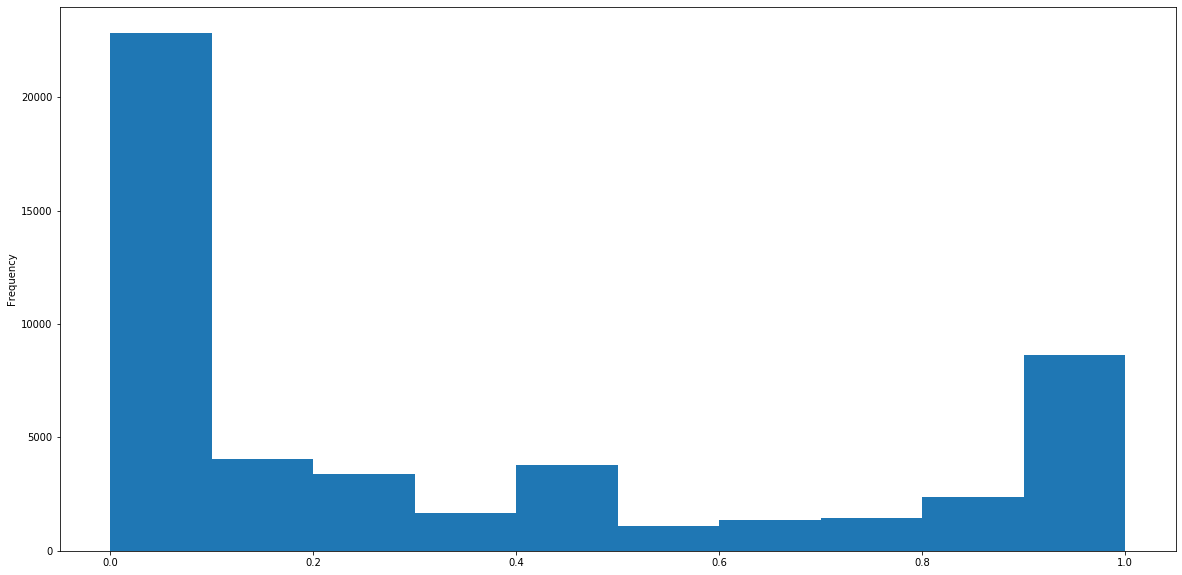

In [41]:
plt = listings_merge.available_year_avg.plot(kind='hist', figsize=(20, 10))

<br/>
<p>Even in a low season like winter, there seems to be low availability.</p>

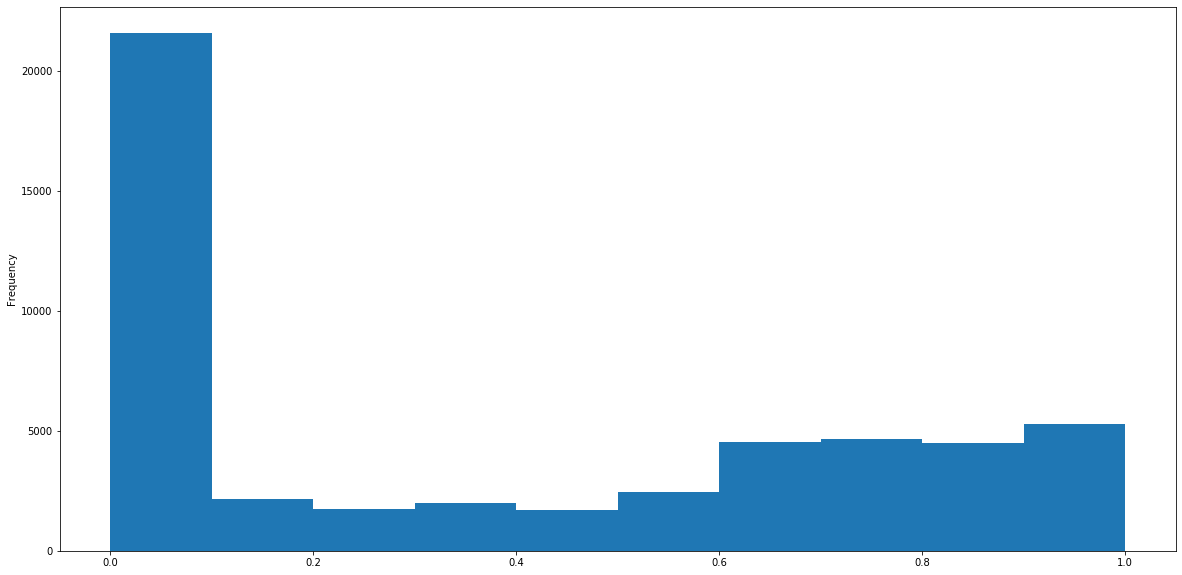

In [42]:
plt = listings_merge.available_winter_avg.plot(kind='hist', figsize=(20, 10))

<br/>
<p>Plotting the log of the minimum nights required we see that it approximates an exponential distribution.</p>

1.000000      11978
2.000000      10881
3.000000       7306
30.000000      3841
4.000000       3065
              ...  
324.715068        1
2.101370          1
5.956164          1
1.838356          1
21.005479         1
Name: min_nights_year_avg, Length: 2013, dtype: int64
30.000000     3841
7.000000      1910
6.000000       693
14.000000      522
10.000000      459
              ... 
14.923288        1
27.920548        1
5.575342         1
30.482192        1
101.054795       1
Name: min_nights_year_avg, Length: 1128, dtype: int64


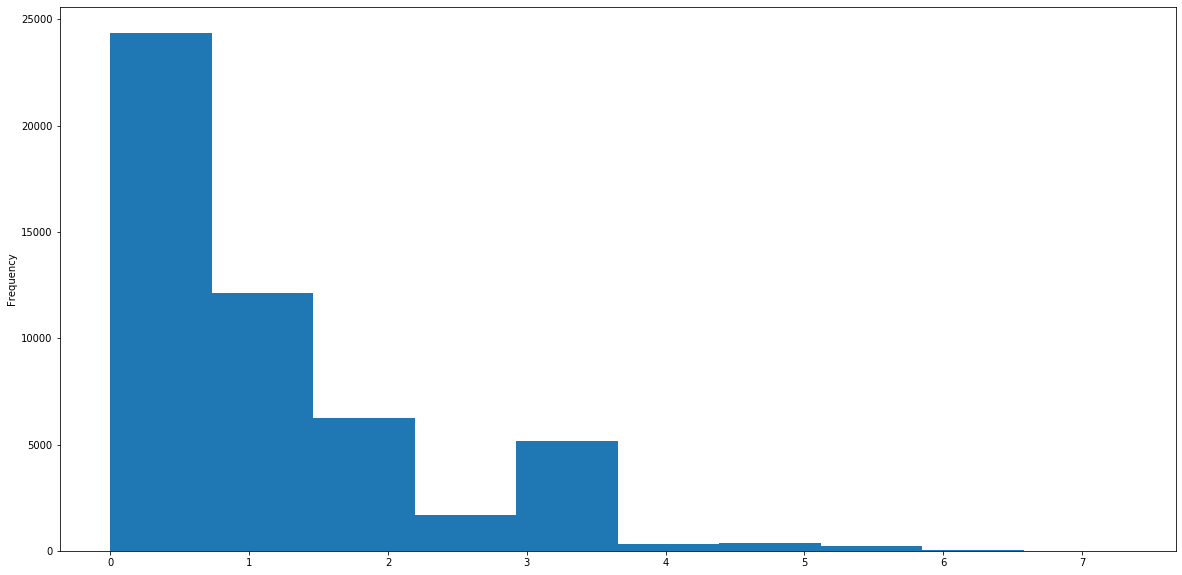

In [43]:
min_nights_75_perc = listings_merge.loc[listings_merge.min_nights_year_avg > 5].min_nights_year_avg.value_counts()
print(listings_merge.min_nights_year_avg.value_counts())
print(min_nights_75_perc)
plt = np.log(listings_merge.min_nights_year_avg).plot(kind='hist', figsize=(20, 10))

<br/>
<p>There isn't much detail in plot of average prices over the year.  We can't plot the log of average prices due to some zero values that need to be cleaned up.</p>

150.000000    940
100.000000    859
200.000000    697
50.000000     596
60.000000     557
             ... 
54.109589       1
217.956164      1
425.205479      1
149.298630      1
185.235616      1
Name: price_year_avg, Length: 24572, dtype: int64
200.000000    697
250.000000    471
300.000000    254
225.000000    176
350.000000    169
             ... 
200.890411      1
213.824658      1
285.073973      1
415.646575      1
188.323288      1
Name: price_year_avg, Length: 7347, dtype: int64


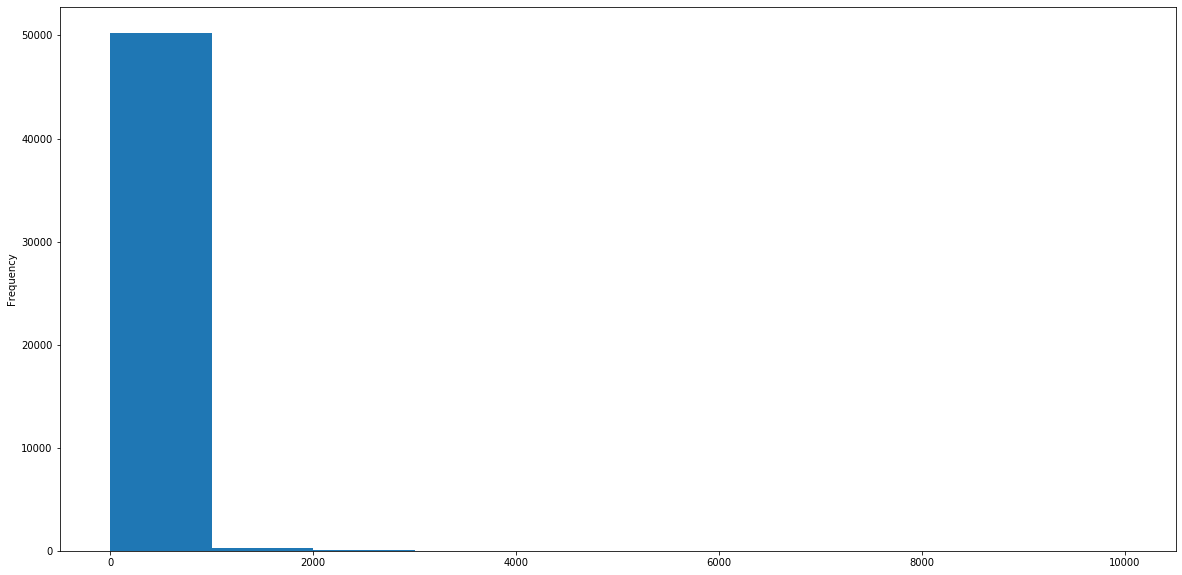

In [44]:
price_75_perc = listings_merge.loc[listings_merge.price_year_avg > 180].price_year_avg.value_counts()
print(listings_merge.price_year_avg.value_counts())
print(price_75_perc)
plt = listings_merge.price_year_avg.plot(kind='hist', figsize=(20, 10))

<br/>
<p>Use a similar method as with the <b>listings_clean</b> table to average over a 200 m radius from listings that have 0, missing, or outlier values for prices.</p>

In [45]:
print(listings_merge.columns)
print(listings_merge.columns[22], listings_merge.columns[23], listings_merge.columns[24], \
      listings_merge.columns[25], listings_merge.columns[26])

Index(['id', 'neighbourhood', 'neighbourhood_group', 'latitude', 'longitude',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'room_type_cat', 'neighbourhood_group_cat', 'available_year_avg',
       'available_winter_avg', 'available_spring_avg', 'available_summer_avg',
       'available_fall_avg', 'min_nights_year_avg', 'min_nights_winter_avg',
       'min_nights_spring_avg', 'min_nights_summer_avg', 'min_nights_fall_avg',
       'price_year_avg', 'price_winter_avg', 'price_spring_avg',
       'price_summer_avg', 'price_fall_avg'],
      dtype='object')
price_year_avg price_winter_avg price_spring_avg price_summer_avg price_fall_avg


In [46]:
listings_merge.head()

,id,neighbourhood,neighbourhood_group,latitude,longitude,room_type,accommodates,bathrooms,bedrooms,beds,...,min_nights_year_avg,min_nights_winter_avg,min_nights_spring_avg,min_nights_summer_avg,min_nights_fall_avg,price_year_avg,price_winter_avg,price_spring_avg,price_summer_avg,price_fall_avg
0,2595,Midtown,Manhattan,40.75362,-73.98377,Entire home/apt,1,1.0,1.0,1.0,...,10.000000,10.000000,10.000000,10.0,10.0,196.334247,177.255556,176.152174,215.728261,216.0
1,3831,Clinton Hill,Brooklyn,40.68514,-73.95976,Entire home/apt,3,1.0,1.0,4.0,...,1.000000,1.000000,1.000000,1.0,1.0,86.224658,88.911111,86.032609,85.000000,85.0
2,5099,Murray Hill,Manhattan,40.74767,-73.97500,Entire home/apt,2,1.0,1.0,1.0,...,3.000000,3.000000,3.000000,3.0,3.0,206.164384,225.000000,200.000000,200.000000,200.0
3,5121,Bedford-Stuyvesant,Brooklyn,40.68688,-73.95596,Private room,2,1.0,1.0,1.0,...,29.000000,29.000000,29.000000,29.0,29.0,60.000000,60.000000,60.000000,60.000000,60.0
4,5178,Hell's Kitchen,Manhattan,40.76489,-73.98493,Private room,2,1.0,1.0,1.0,...,1.750685,1.344444,1.652174,2.0,2.0,78.279452,77.233333,77.869565,79.000000,79.0


In [47]:
# https://gizmodo.com/how-precise-is-one-degree-of-longitude-or-latitude-1631241162
# averaging over approximate radius of 100 m from listings
# that have 0, NaN, or greater than threshold price values

lat_diff = 0.002
long_diff = 0.002
def avg_of_neighbors_2(row, col_name, col_index, thresh):
    item = row[col_index]
    room_type = row[5]
    lat = row[3]
    long = row[4]
    if item == 0 or math.isnan(item) or item > thresh:
        if room_type == 'Entire home/apt':
            item = listings_merge[col_name].loc[(listings_clean.latitude > lat - lat_diff) \
                & (listings_merge.latitude < lat + lat_diff) \
                & (listings_merge.longitude > long - long_diff) \
                & (listings_merge.longitude < long + long_diff)
                & (listings_merge.room_type == 'Entire home/apt')].groupby(by=listings_merge.neighbourhood).mean().round()[0]
        else:
            item = listings_merge[col_name].loc[(listings_clean.latitude > lat - lat_diff) \
                & (listings_merge.latitude < lat + lat_diff) \
                & (listings_merge.longitude > long - long_diff) \
                & (listings_merge.longitude < long + long_diff)
                & (listings_merge.room_type != 'Entire home/apt')].groupby(by=listings_merge.neighbourhood).mean().round()[0]
        if item == 0:
            item = 1
        row[col_index] = item
    return row

listings_merge = listings_merge.apply(avg_of_neighbors_2, col_name='price_year_avg', col_index=22, axis=1, thresh=1000)
listings_merge = listings_merge.apply(avg_of_neighbors_2, col_name='price_winter_avg', col_index=23, axis=1, thresh=1000)
listings_merge = listings_merge.apply(avg_of_neighbors_2, col_name='price_spring_avg', col_index=24, axis=1, thresh=1000)
listings_merge = listings_merge.apply(avg_of_neighbors_2, col_name='price_summer_avg', col_index=25, axis=1, thresh=1000)
listings_merge = listings_merge.apply(avg_of_neighbors_2, col_name='price_fall_avg', col_index=26, axis=1, thresh=1000)


<br/>
<p>After some cleanup and taking the log of prices averaged over the year, we see an approximate normal distribution.</p>

5.010635    940
4.605170    862
5.298317    697
3.912023    596
4.094345    558
           ... 
5.101486      1
5.176506      1
4.779469      1
3.809702      1
4.052237      1
Name: price_year_avg, Length: 24470, dtype: int64


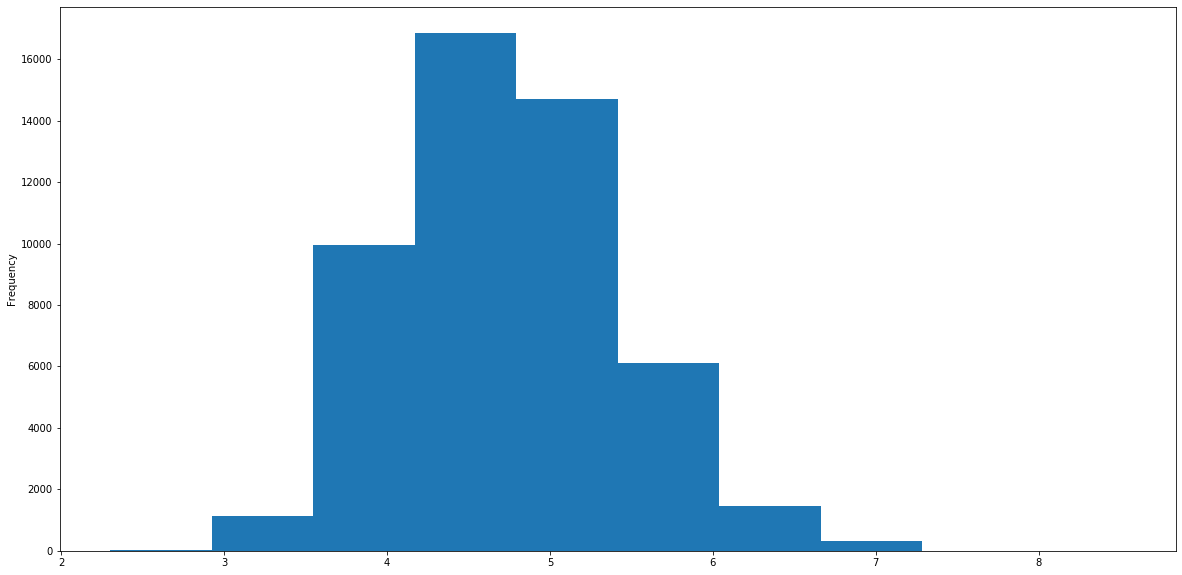

In [48]:
print(np.log(listings_merge.price_year_avg).value_counts())
plt = np.log(listings_merge.price_year_avg).plot(kind='hist', figsize=(20, 10))

<br/>
<p>Even after the cleaning process, we find that there is still a missing <b>price_fall_avg</b> value.  Averaging over nearest neighbors didn't catch everything!</p>

In [49]:
listings_merge.info()
listings_merge.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50586 entries, 0 to 50586
Data columns (total 27 columns):
id                         50586 non-null int64
neighbourhood              50586 non-null object
neighbourhood_group        50586 non-null object
latitude                   50586 non-null float64
longitude                  50586 non-null float64
room_type                  50586 non-null object
accommodates               50586 non-null int64
bathrooms                  50586 non-null float64
bedrooms                   50586 non-null float64
beds                       50586 non-null float64
room_type_cat              50586 non-null object
neighbourhood_group_cat    50586 non-null object
available_year_avg         50586 non-null float64
available_winter_avg       50586 non-null float64
available_spring_avg       50586 non-null float64
available_summer_avg       50586 non-null float64
available_fall_avg         50586 non-null float64
min_nights_year_avg        50586 non-null float64


,id,latitude,longitude,accommodates,bathrooms,bedrooms,beds,available_year_avg,available_winter_avg,available_spring_avg,...,min_nights_year_avg,min_nights_winter_avg,min_nights_spring_avg,min_nights_summer_avg,min_nights_fall_avg,price_year_avg,price_winter_avg,price_spring_avg,price_summer_avg,price_fall_avg
count,5.058600e+04,50586.000000,50586.000000,50586.000000,50586.000000,50586.000000,50586.000000,50586.000000,50586.000000,50586.000000,...,50586.000000,50586.000000,50586.000000,50586.000000,50586.000000,50586.000000,50586.000000,50586.000000,50586.000000,50585.000000
mean,2.137339e+07,40.728743,-73.950755,2.860633,1.152552,1.276144,1.583323,0.332734,0.376502,0.373997,...,8.524899,8.002959,8.672950,8.730713,8.683346,146.192565,140.346189,145.555426,147.905998,149.094326
std,1.242883e+07,0.055010,0.047609,1.900965,0.438504,0.668315,1.102132,0.375598,0.371108,0.450142,...,28.838694,25.749922,31.894554,30.650612,30.347880,133.397210,124.482150,131.232383,132.749987,161.178184
min,2.595000e+03,40.499790,-74.247870,1.000000,0.500000,1.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,10.000000,10.000000,10.000000,10.000000
25%,1.009824e+07,40.689540,-73.982910,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,1.287671,1.288889,1.293478,1.282609,1.285714,68.943151,66.213889,68.347826,69.978261,69.472527
50%,2.154624e+07,40.722875,-73.955050,2.000000,1.000000,1.000000,1.000000,0.172603,0.288889,0.043478,...,2.986301,2.955556,3.000000,3.000000,3.000000,109.036986,105.733333,108.472826,110.000000,110.000000
75%,3.271752e+07,40.763038,-73.934182,4.000000,1.000000,1.000000,2.000000,0.687671,0.733333,1.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,179.935616,175.000000,179.562500,180.000000,180.000000
max,4.058402e+07,40.916860,-73.712990,25.000000,15.500000,21.000000,40.000000,1.000000,1.000000,1.000000,...,1494.104110,1997.166667,2837.565217,1250.000000,1250.000000,5063.000000,5066.000000,5063.000000,5062.000000,9786.000000


<br/>
<p>All prices are $65 for this particular listing, so just use that to fill in the missing value.</p>

In [50]:
listings_merge.loc[np.isnan(listings_merge.price_fall_avg)]

,id,neighbourhood,neighbourhood_group,latitude,longitude,room_type,accommodates,bathrooms,bedrooms,beds,...,min_nights_year_avg,min_nights_winter_avg,min_nights_spring_avg,min_nights_summer_avg,min_nights_fall_avg,price_year_avg,price_winter_avg,price_spring_avg,price_summer_avg,price_fall_avg
30011,25519971,Brownsville,Brooklyn,40.65832,-73.90486,Private room,1,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,65.0,65.0,65.0,65.0,NaN


In [51]:
listings_merge.loc[np.isnan(listings_merge.price_fall_avg), 'price_fall_avg'] = 65
listings_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50586 entries, 0 to 50586
Data columns (total 27 columns):
id                         50586 non-null int64
neighbourhood              50586 non-null object
neighbourhood_group        50586 non-null object
latitude                   50586 non-null float64
longitude                  50586 non-null float64
room_type                  50586 non-null object
accommodates               50586 non-null int64
bathrooms                  50586 non-null float64
bedrooms                   50586 non-null float64
beds                       50586 non-null float64
room_type_cat              50586 non-null object
neighbourhood_group_cat    50586 non-null object
available_year_avg         50586 non-null float64
available_winter_avg       50586 non-null float64
available_spring_avg       50586 non-null float64
available_summer_avg       50586 non-null float64
available_fall_avg         50586 non-null float64
min_nights_year_avg        50586 non-null float64


<p>Perhaps we can add more features like monthly averages for availability, minimum nights required, and price, but that would make the table size explode!<p>

In [92]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

listings_numeric = listings_merge.drop([
    'neighbourhood', 'neighbourhood_group', 'room_type', 'room_type_cat', 'neighbourhood_group_cat'
], axis=1)
X = listings_numeric.drop([
    'price_year_avg', 'price_winter_avg', 'price_spring_avg', 'price_summer_avg', 'price_fall_avg',
    'available_year_avg', 'available_winter_avg', 'available_spring_avg', 'available_summer_avg', 'available_fall_avg'
], axis=1)
label_list = [
    'available_year_avg', 'available_winter_avg', 'available_spring_avg', 'available_summer_avg', 'available_fall_avg'
]

for label in label_list:
    y = listings_merge[label]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42, shuffle=True)
    print('y:', label)

    clf = LinearRegression()
    clf.fit(X_train, y_train)
    print(clf.score(X_test, y_test))

    clf2 = RandomForestRegressor()
    clf2.fit(X_train, y_train)
    print(clf2.score(X_test, y_test))

y: available_year_avg
(37939, 12)
0.058603645391009596
0.28814903627075206
y: available_winter_avg
(37939, 12)
0.08452075462884479
0.25561783105916036
y: available_spring_avg
(37939, 12)
0.04779436524869485
0.2349810406307743
y: available_summer_avg
(37939, 12)
0.046101041354879024
0.25046136472603453
y: available_fall_avg
(37939, 12)
0.04964573301984021
0.2476081749229044


In [91]:
label_list = ['price_year_avg', 'price_winter_avg', 'price_spring_avg', 'price_summer_avg', 'price_fall_avg']

for label in label_list:
    y = listings_merge[label]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42, shuffle=True)
    print('y:', label)
    print(X_train.shape)

    clf = LinearRegression()
    clf.fit(X_train, y_train)
    print(clf.score(X_test, y_test))

    clf2 = RandomForestRegressor()
    clf2.fit(X_train, y_train)
    print(clf2.score(X_test, y_test))

y: price_year_avg
(37939, 12)
0.3055187808368759
0.46312936098287005
y: price_winter_avg
(37939, 12)
0.3100728248168998
0.43499448431322285
y: price_spring_avg
(37939, 12)
0.321158077418505
0.4701506652815465
y: price_summer_avg
(37939, 12)
0.326462341778187
0.4699045580623755
y: price_fall_avg
(37939, 12)
0.1959339848117102
0.5415648817806866


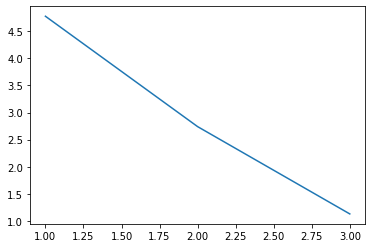

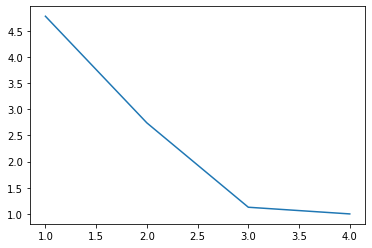

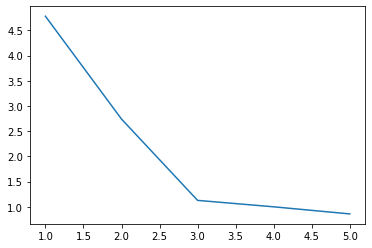

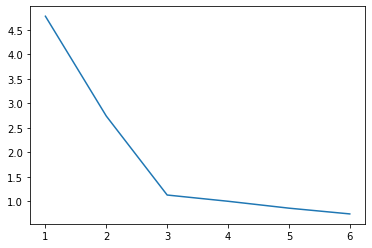

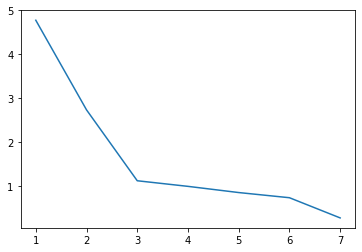

In [102]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

scaler = StandardScaler()
pca = PCA(n_components=8)

X_scaled = scaler.fit_transform(X)

comp_range = range(3,8)

for n_comp in comp_range: 
    pca.n_components = n_comp
    pca.fit(X_scaled)
    plt.plot(range(1, n_comp + 1), pca.explained_variance_)
    plt.show()

In [109]:
# https://stackoverflow.com/questions/25475465/how-to-normalize-with-pca-and-scikit-learn
from sklearn.pipeline import Pipeline

label_list = ['price_year_avg', 'price_winter_avg', 'price_spring_avg', 'price_summer_avg', 'price_fall_avg']

for label in label_list:
    y = listings_merge[label]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42, shuffle=True)
    print('y:', label)
    
    pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=3)), ('regr', LinearRegression())])
    pipeline.fit(X_train, y_train)
    print(pipeline.score(X_test, y_test))


y: price_year_avg
0.23176556578251273
y: price_winter_avg
0.24087503021077583
y: price_spring_avg
0.24389479488711086
y: price_summer_avg
0.24608784446326692
y: price_fall_avg
0.1432779398808709


In [112]:
from sklearn.model_selection import GridSearchCV

y = listings_merge['price_year_avg']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42, shuffle=True)
clf = RandomForestRegressor()

params = {
    'max_depth': [2, 4, 6, 8],
    'min_samples_split': [4, 8, 16],
    'min_samples_leaf': [2, 4, 8],
    'max_features': [1, 5, 10]
}
grid = GridSearchCV(clf, param_grid=params)
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.best_params_)

0.5046373564139686
{'max_depth': 8, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 4}
